## Семинар 8: "Снижение размерности"

ФИО: Дегтярев Роман Олегович

In [101]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import sys
from torch import optim
from sklearn.decomposition import PCA
%matplotlib inline

Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [114]:
X = fetch_olivetti_faces()['data']

In [115]:
X.shape

(400, 4096)

In [116]:
model = PCA(n_components=25)
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [117]:
principle_components = model.components_

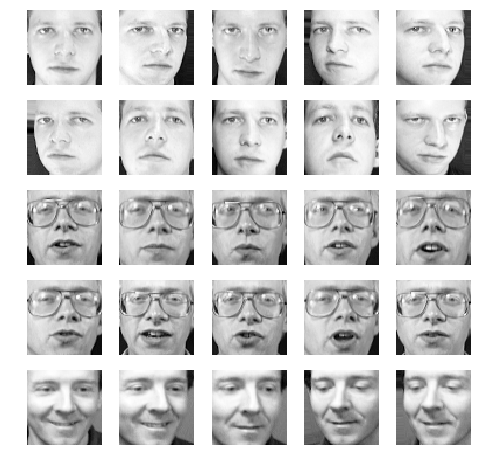

In [118]:
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

Подсказка: используйте метод <b>.components_</b>

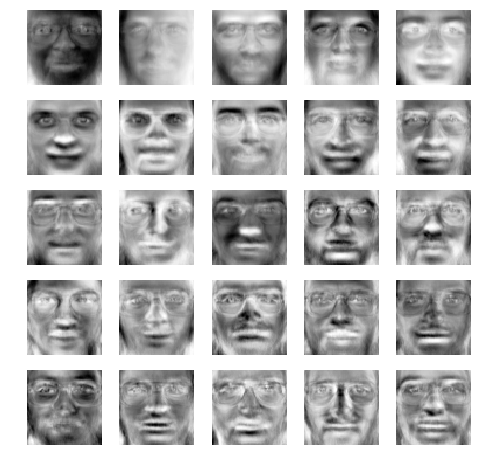

In [119]:
#xrange - итератор, в памяти ничего не сохраняется
#range(список)
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(principle_components[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

In [120]:
embeding = model.transform(X)
recorstruction = model.inverse_transform(embeding)
recorstruction.shape, embeding.shape
error = ((recorstruction - X)**2).sum()
print('Ошибка реконструкции: {}'.format(((recorstruction - X)**2).sum()))

Ошибка реконструкции: 6519.1730194


<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>

Подсказка: используйте методы <b>.transform</b> и <b>.inverse_transform</b>

In [121]:
#подсчитаем 
model = PCA()
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

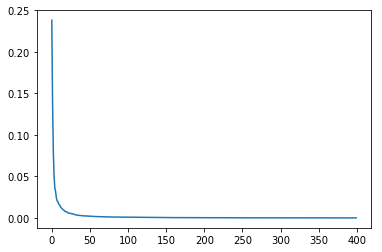

In [122]:
plt.plot(model.explained_variance_ratio_)

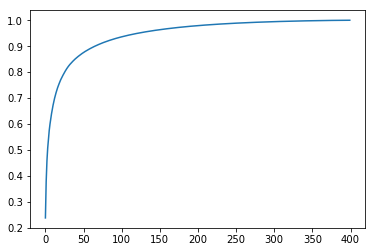

In [201]:
plt.plot(np.cumsum(model.explained_variance_ratio_))
#В сингулярном разложении дисперсия на диагонали в ковариационной матрице - это ошибки
#np.cumsum - возвращает накопленную сумму вдоль выбранной оси, если такая указана. 
#model.explained_variance_ratio_ - доля объяснённых дисперсий

In [124]:
embeding = model.transform(X)
recorstruction = model.inverse_transform(embeding)
recorstruction.shape, embeding.shape
error = ((recorstruction - X)**2).sum()
print('Ошибка реконструкции: {}'.format(((recorstruction - X)**2).sum()))

Ошибка реконструкции: 2.6010950429e-25


In [185]:
def visualpca(X, num_components, idx):
    model = PCA(n_components=num_components)
    model.fit(X)
    embeding = model.transform(X)
    recorstruction = model.inverse_transform(embeding)
    error = X-reconstruction
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,4))
    ax1.set_title('Before')
    ax1.imshow((X)[idx].reshape(64,64), cmap='gray')
    ax2.set_title('After')
    ax2.imshow((recorstruction)[idx].reshape(64,64), cmap='gray') 
    ax3.set_title('Error')
    plt.imshow((error)[idx].reshape(64,64), cmap='gray')
    plt.colorbar()
    plt.show()

Number of components: 0


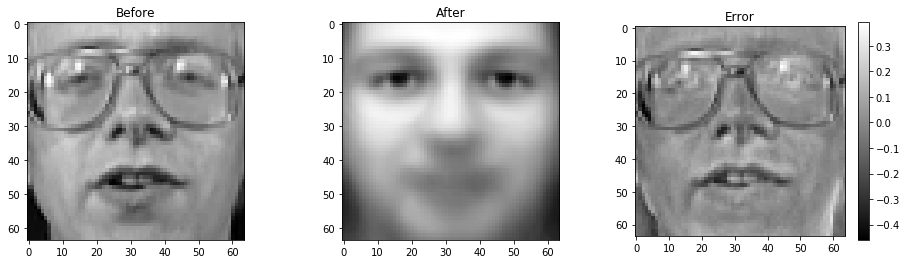

Number of components: 100


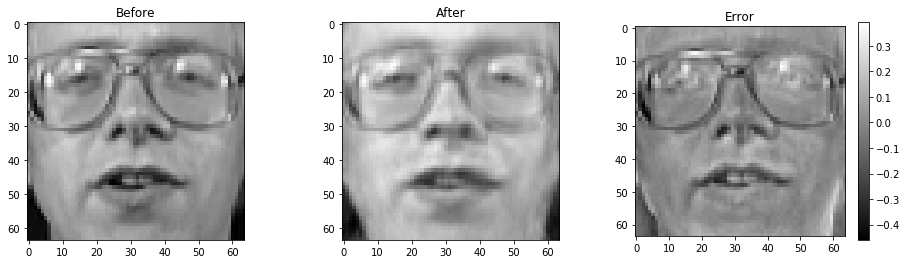

Number of components: 200


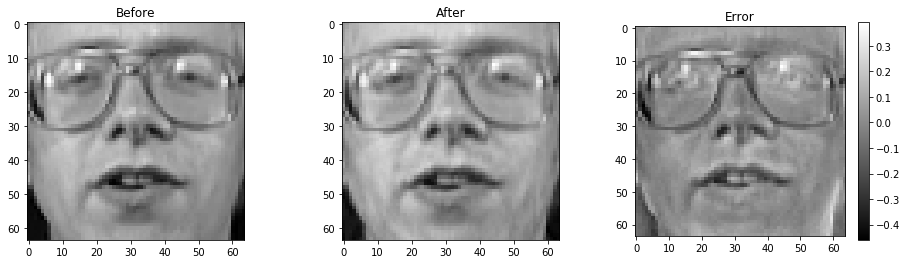

In [200]:
for i in xrange(0,300,100):
    print('Number of components: {}'. format(i))
    visualpca(X,i,10)

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

In [29]:
#Вывод: 100 компонент - самое оптимальное

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [202]:
model = PCA(n_components=2)
model.fit(X)
embeding = model.transform(X)

In [203]:
def plot_dataset(X, emb, margin=50, frame=2000., imsize=64):
    assert(emb.shape[1] == 2)
    emb = np.array((emb - emb.min(0)) * (frame / (emb.max(0) - emb.min(0))) + margin, dtype = np.int)
    image = np.zeros((int(emb[:, 0].max() + margin + imsize), int(emb[:, 1].max() + margin + imsize))) + 1
    for k in xrange(X.shape[0]):
        image[emb[k, 0]:emb[k, 0]+64, emb[k, 1]:emb[k, 1]+64] = X[k].reshape(64, 64)
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

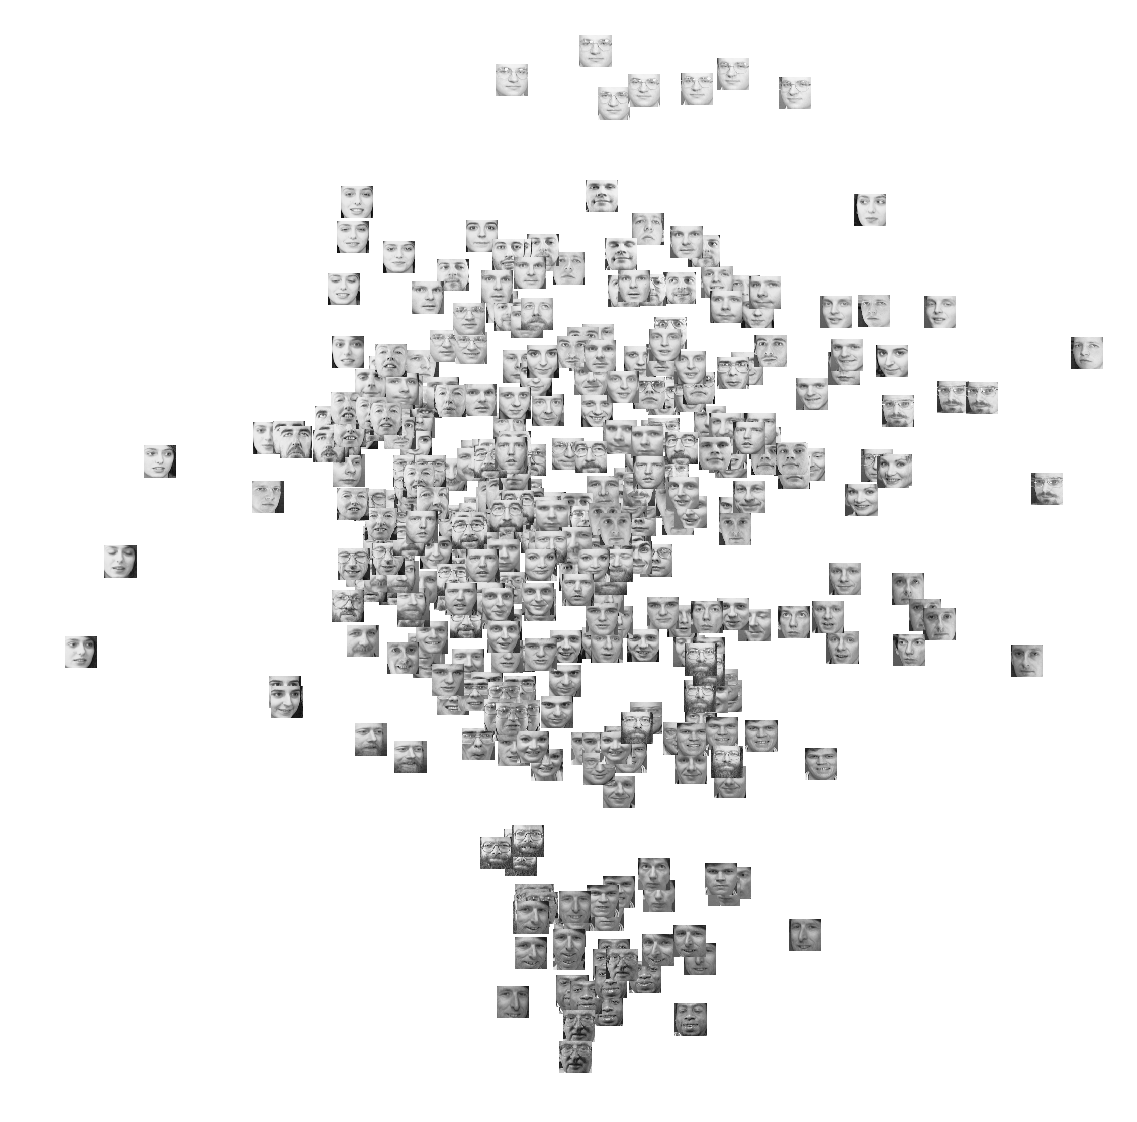

In [204]:
plot_dataset(X, embeding)

In [48]:
#первая компонента отвечает за свет
#вторая - отвечает за в то, в какаую сторону смотрит человек

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте LeakyReLU().</i>

In [209]:
from torch.utils.data import DataLoader, Dataset

In [210]:
class FacesDataset(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return X[idx]

In [211]:
dataset = FacesDataset(X)
dataloader = DataLoader(dataset, batch_size=16, shuffle = True)

In [212]:
def fully_connected(arc, last_nonlinearity=True):
    layers = []
    for i in range(len(arc)-1):
        layers.append(nn.Linear(arc[i], arc[i+1]))
        if i != len(arc)-2 or last_nonlinearity:
            layers.append(nn.LeakyReLU())
    return nn.Sequential(*layers)

In [213]:
fully_connected([4096, 200, 10], last_nonlinearity=False)

Sequential (
  (0): Linear (4096 -> 200)
  (1): LeakyReLU (0.01)
  (2): Linear (200 -> 10)
)

In [214]:
class AE(nn.Module):
    def __init__(self, arc_encoder, arc_decoder):
        super(AE, self).__init__()
        #create encoder
        
        self.encoder = fully_connected(arc_encoder)
        self.decoder = fully_connected(arc_decoder)
        
    def forward(self, X):
        return self.decoder(self.encoder(X))

In [223]:
model = AE([4096, 200, 10], [10,200,4096])
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in xrange(10):
    losses =[]
    for x in dataloader:
        x_batch = Variable(x)
        y_batch = Variable(x, requires_grad = False)
        model.zero_grad()
        x_reconstruction = model(x_batch)
        loss_batch = loss(x_reconstruction, y_batch)
        loss_batch.backward()
        optimizer.step()
        losses.append(loss_batch.data[0])
    sys.stdout.write('\r {}'.format(np.mean(losses)))

 0.0113665077463

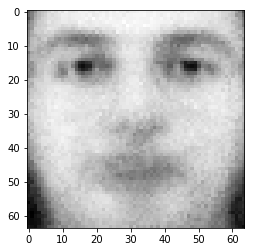

In [224]:
embedding = model.encoder(Variable(torch.Tensor(X))).data.numpy()
reconstruction = model(Variable(torch.Tensor(X))).data.numpy()
plt.imshow(reconstruction[0].reshape(64,64), cmap=plt.cm.Greys_r)

<i> 2.2 Какое качество восстановления удалось получить?</i>

In [221]:
#У PCA можно аналитически найти embedding 
#У декодера стохастическим градиентом все происходит, а из-за этого и качество автоматически хуже

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

In [229]:
model = AE([4096, 20, 10], [10,20,4096])
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in xrange(10):
    losses =[]
    for x in dataloader:
        x_batch = Variable(x)
        y_batch = Variable(x, requires_grad = False)
        model.zero_grad()
        x_reconstruction = model(x_batch)
        loss_batch = loss(x_reconstruction, y_batch)
        loss_batch.backward()
        optimizer.step()
        losses.append(loss_batch.data[0])
    sys.stdout.write('\r {}'.format(np.mean(losses)))

 0.0154970075935

In [230]:
embedding_ = model.encoder(Variable(torch.Tensor(X))).data.numpy()
reconstruction_ = model(Variable(torch.Tensor(X))).data.numpy()

In [249]:
model = AE([4096, 2000, 10], [10,2000,4096])
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in xrange(50):
    losses =[]
    for x in dataloader:
        x_batch = Variable(x)
        y_batch = Variable(x, requires_grad = False)
        model.zero_grad()
        x_reconstruction = model(x_batch)
        loss_batch = loss(x_reconstruction, y_batch)
        loss_batch.backward()
        optimizer.step()
        losses.append(loss_batch.data[0])
    sys.stdout.write('\r {}'.format(np.mean(losses)))

 0.0105567293614

In [250]:
embedding__ = model.encoder(Variable(torch.Tensor(X))).data.numpy()
reconstruction__ = model(Variable(torch.Tensor(X))).data.numpy()

In [253]:
#PCA
model = PCA()
model.fit(X)
embeding = model.transform(X)
recorstructionpca = model.inverse_transform(embeding)

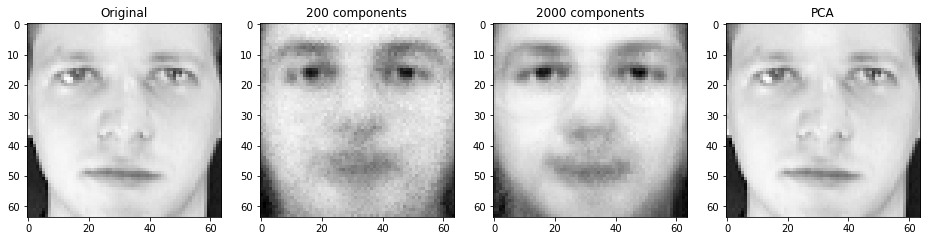

In [262]:
fig, (ax0,ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16,5)) 
ax0.set_title('Original')
ax0.imshow(X[0].reshape(64,64), cmap=plt.cm.Greys_r)

ax1.set_title('hidden: 200')
ax1.imshow(reconstruction[0].reshape(64,64), cmap=plt.cm.Greys_r)

ax2.set_title('hidden: 2000')
ax2.imshow(reconstruction__[0].reshape(64,64), cmap=plt.cm.Greys_r)

ax3.set_title('PCA')
plt.imshow(recorstructionpca[0].reshape(64,64), cmap=plt.cm.Greys_r)
plt.show()

In [ ]:
plt.plot(losses, range(0,50))

<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

In [263]:
#Не удалось полностью восстановить картинку, в отличие от PCA. 
#Главное преимущество PCA - это то, что он позволяет найти отображение аналитически.

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [268]:
model = AE([4096, 200, 2], [2,200,4096])
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in xrange(50):
    losses =[]
    for x in dataloader:
        x_batch = Variable(x)
        y_batch = Variable(x, requires_grad = False)
        model.zero_grad()
        x_reconstruction = model(x_batch)
        loss_batch = loss(x_reconstruction, y_batch)
        loss_batch.backward()
        optimizer.step()
        losses.append(loss_batch.data[0])
    sys.stdout.write('\r {}'.format(np.mean(losses)))

 0.0148730098084

In [269]:
embedding___ = model.encoder(Variable(torch.Tensor(X))).data.numpy()

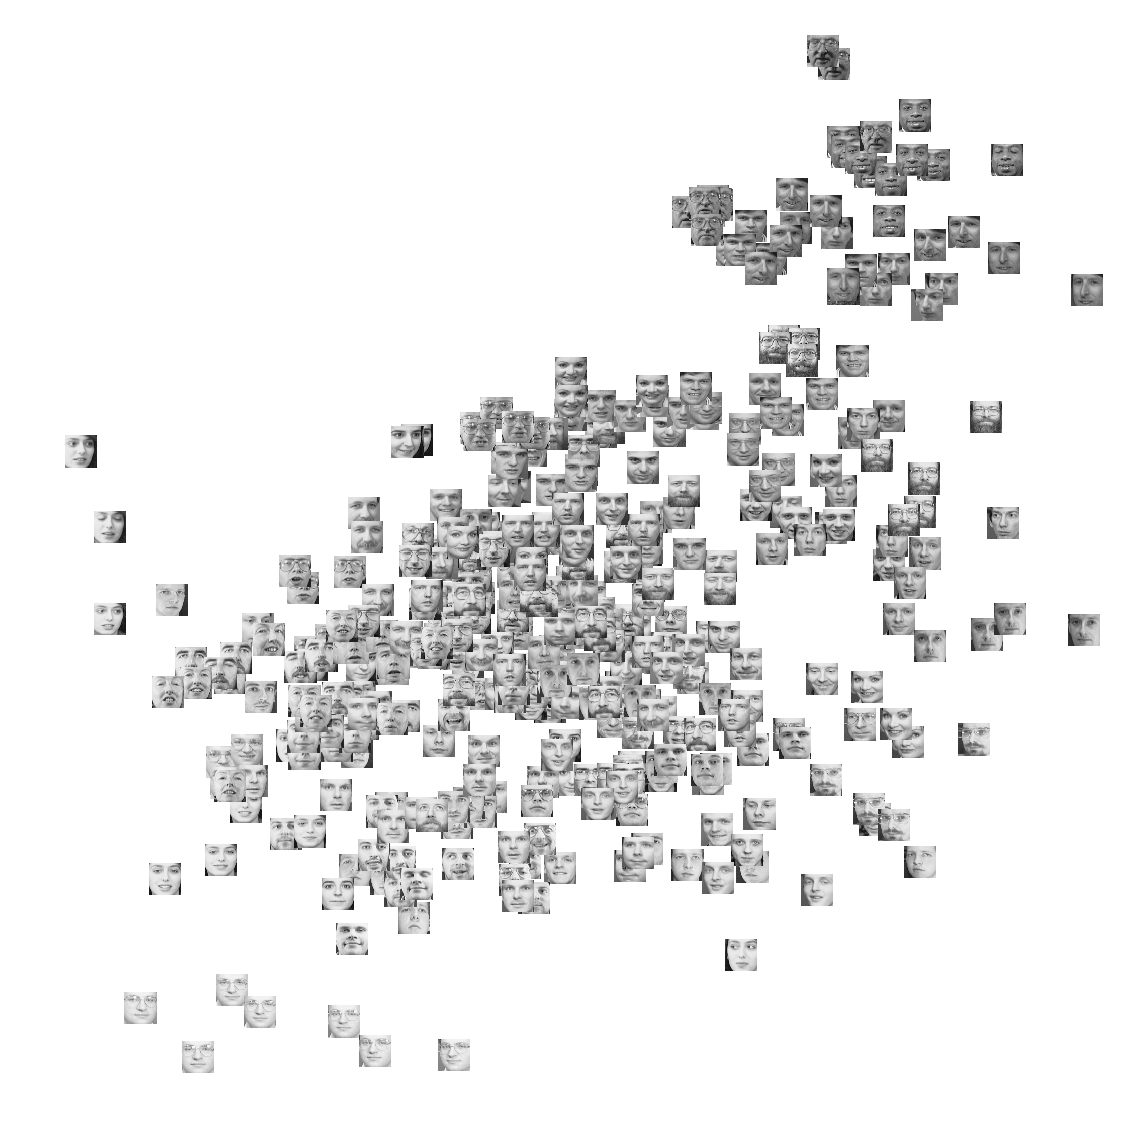

In [270]:
plot_dataset(X, embedding___)

In [271]:
#В итоге выделились те же калстера, что и в PCA: светлые - внизу, тёмные - вверху. 
#Если смотрят влево  - то находятся слева, если вправо - то наоборот.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: